In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [2]:
df = pd.read_csv('carga_gw_2020.csv', sep = ';', engine = 'python', header=None)

In [3]:
df.head()

,0,1
0,01/01/2018,"1.264,5"
1,02/01/2018,"1.519,40"
2,03/01/2018,"1.591,30"
3,04/01/2018,"1.588,70"
4,05/01/2018,"1.594,70"


In [4]:
dataframe = df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       912 non-null    object
 1   1       912 non-null    object
dtypes: object(2)
memory usage: 14.4+ KB


In [6]:
def to_numeric(x): 
    
    x = x.replace(',','.')
    sep = x.split('.')
    
    if len(sep) == 2:
        x = sep[0]+'.'+sep[1]
        
        
    elif len(sep) ==3 :
        x = sep[0]+sep[1]+'.'+sep[2]
    
    else:
        x = 0
    
    x_num = pd.to_numeric(x)

    return  x_num


In [7]:
def preprocess_df(df):
        
    # Determina novos nome de colunas
    df.columns = ["Date", "Carga"]
    
    df.Date = pd.to_datetime(df.Date, dayfirst= True)
    df.dtypes
    
    # Transforma colunas em numericos 
    df['Carga'] = pd.to_numeric(df['Carga'].apply(to_numeric))
    
    
    
    # Associa coluna Date ao index
    df.index = pd.to_datetime(df.Date, format="%m-%d-%Y")
     #dropa coluna Date extra 
    df.drop("Date", axis=1, inplace=True)
    
    return df

In [8]:
def fill_na_with_mean(df):
    
    num_cols = len(list(df.columns.values))
    
    for col in range(num_cols):
        
        df.iloc[:,col] = df.iloc[:,col].fillna(df.iloc[:,col].mean())
        
    return df

In [9]:
df = preprocess_df(df)
df = fill_na_with_mean(df)
    
df.head()

,Carga
Date,
2018-01-01,1264.5
2018-01-02,1519.4
2018-01-03,1591.3
2018-01-04,1588.7
2018-01-05,1594.7


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 912 entries, 2018-01-01 to 2020-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Carga   912 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


In [11]:
df.isnull().sum()

Carga    0
dtype: int64

In [12]:
carga = df['Carga']

display('Carga:', type(carga))
print()
display('Shape:',carga.shape)
print()
carga.head()

'Carga:'

pandas.core.series.Series

'Shape:'

(912,)

Date
2018-01-01    1264.5
2018-01-02    1519.4
2018-01-03    1591.3
2018-01-04    1588.7
2018-01-05    1594.7
Name: Carga, dtype: float64

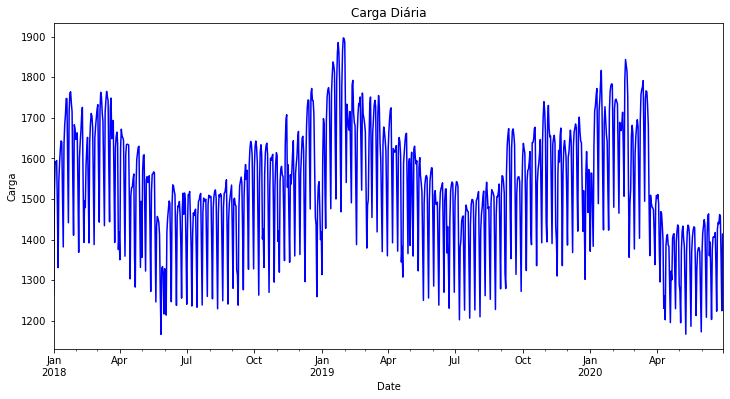

In [13]:
# visualizacao dos dados 
plt.figure(figsize = (12,6))
carga.plot(title = 'Carga Diária', color = 'blue')
plt.ylabel('Carga')
plt.show()

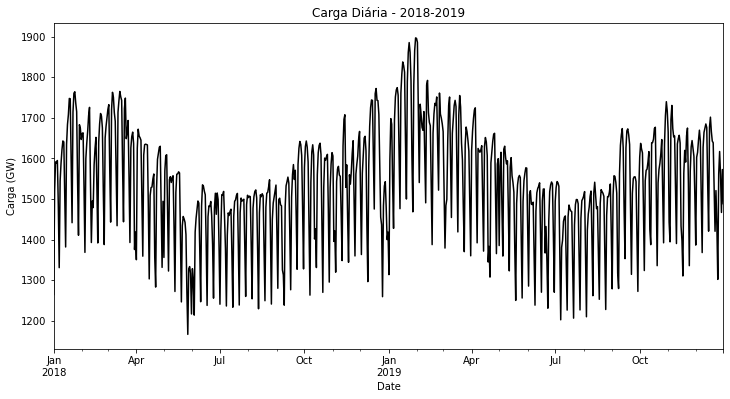

In [14]:
 #Separando os dados da serie temporal
final_2019 = 730
plt.figure(figsize = (12,6))
carga[0:final_2019].plot(title = 'Carga Diária - 2018-2019', color = 'black')
plt.ylabel('Carga (GW)')
plt.show()

In [15]:
carga[0:final_2019].tail()

Date
2019-12-27    1616.9
2019-12-28    1559.2
2019-12-29    1466.7
2019-12-30    1572.5
2019-12-31    1488.3
Name: Carga, dtype: float64

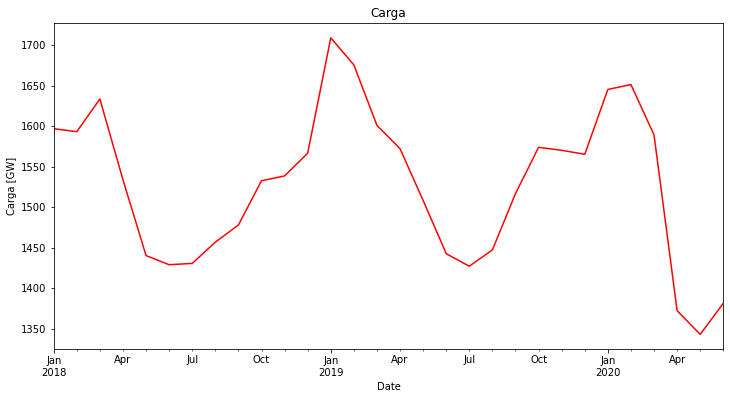

In [16]:
freq = 'M'
# media da carga por mes
media_carga_df = carga.resample(freq).mean()

# Display plot
plt.figure(figsize = (12,6))
media_carga_df.plot(title = 'Carga', color = 'red')
plt.ylabel('Carga [GW]')
plt.show()

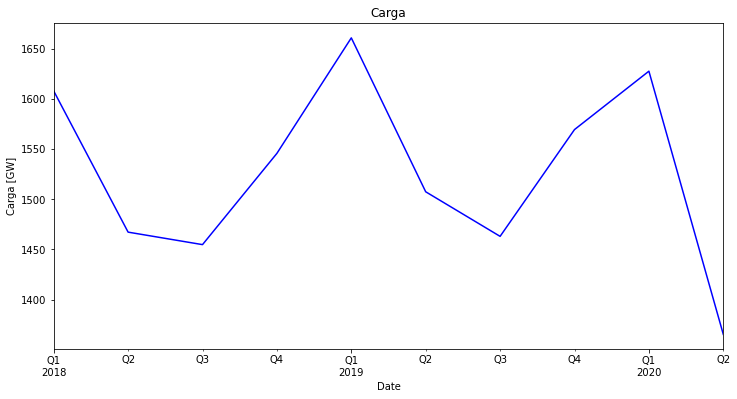

In [17]:
freq = 'Q'
# Calculate energy generation per quarter 
mean_carga_df = carga.resample(freq).mean()

# Display 
plt.figure(figsize = (12,6))
mean_carga_df.plot(title = 'Carga', color = 'blue')
plt.ylabel('Carga [GW]')
plt.show()

In [18]:
def make_time_series(carga_df, years, freq='D', start_idx=0, has_leap_year = None, leap_year = None):
        
    # recebe as series temporais
    time_series = []
    
    if has_leap_year:
        # valor do ano bissexto
        leap = leap_year
    

    # Cria um time series para cada ano da lista years
    for i in range(len(years)):

        year = years[i]
        
        if has_leap_year:
            year == leap
            end_idx = start_idx+366
            
        else:
            end_idx = start_idx+365

        # Cria o inicio e o fim do nosso datetime
        t_start = year + '-01-01' # Primeiro de janeiro e nosso t_start (ou t0)
        t_end = year + '-12-31' # 31 de Dezembro e o t_end

        # Slicing nos dados de energia
        data = carga_df[start_idx:end_idx]

        # Cria time series para cada ano
        index = pd.date_range(start=t_start, end =t_end,  freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # Retorna lista de time series
    return time_series

In [19]:
carga_df = df['Carga']
carga_df.head()

Date
2018-01-01    1264.5
2018-01-02    1519.4
2018-01-03    1591.3
2018-01-04    1588.7
2018-01-05    1594.7
Name: Carga, dtype: float64

In [20]:
# Verificando a funcao
# Time series para cada ano
years = ['2018', '2019']

freq ='D' # frequencia diaria

# Cria time series
time_series = make_time_series(carga_df, years, freq=freq)

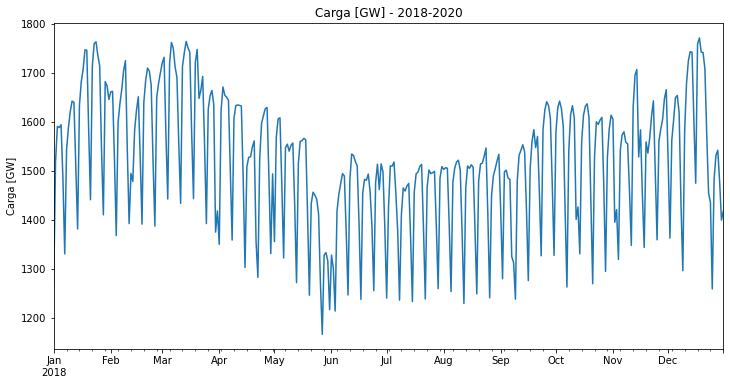

In [21]:
# Primeira serie temporal 
time_series_idx = 0

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot(title = 'Carga [GW] - 2018-2020')
plt.ylabel('Carga [GW]')
plt.show()

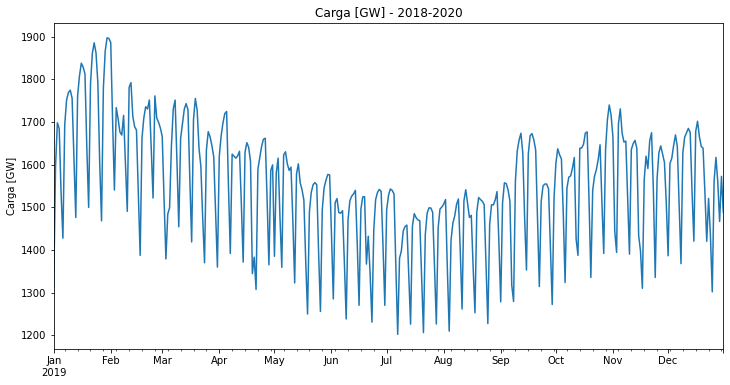

In [22]:
# Display the second time series
time_series_idx = 1

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot(title = 'Carga [GW] - 2018-2020')
plt.ylabel('Carga [GW]')
plt.show()

In [23]:
# Created truncated,training time series
def create_training_series(complete_time_series, prediction_lenght):
    
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        time_series_training.append(ts[: -prediction_lenght])
        
    return time_series_training

In [24]:
prediction_length = 30

time_series_training = create_training_series(time_series, prediction_length)

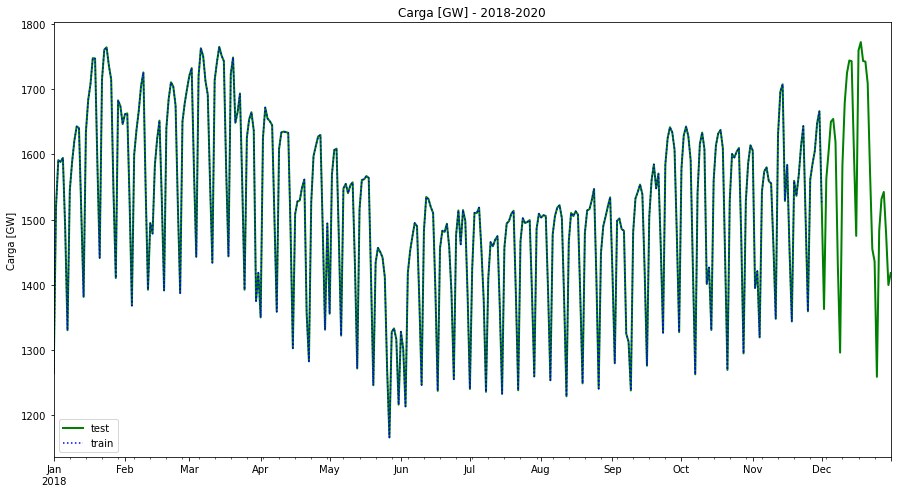

In [25]:
# Mostrar a primeira serie temporal_2018
time_series_idx = 0

plt.figure(figsize=(15,8))

time_series[time_series_idx].plot(label= 'test',color ='g', lw = 2,title = 'Carga [GW] - 2018-2020')

time_series_training[time_series_idx].plot(label= 'train',color = 'b', ls = ':')

plt.ylabel('Carga [GW]')
plt.legend()
plt.show()

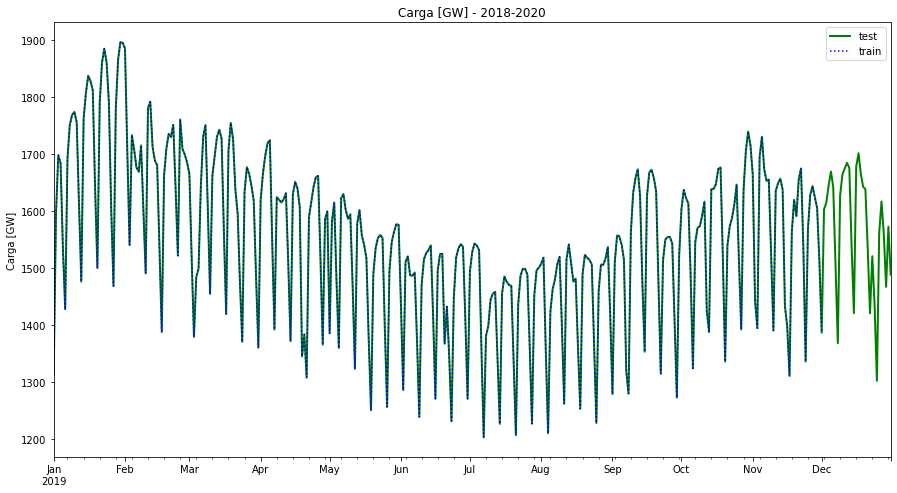

In [26]:
#Mostrar a segunda serie temporal
time_series_idx = 1

plt.figure(figsize=(15,8))

time_series[time_series_idx].plot(label= 'test',color ='g', lw = 2,title = 'Carga [GW] - 2018-2020')

time_series_training[time_series_idx].plot(label= 'train',color = 'b', ls = ':')

plt.ylabel('Carga [GW]')
plt.legend()
plt.show()

In [27]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df.Carga)


In [28]:
gdp_decomp = df[['Carga']].copy()
gdp_decomp["cycle"] = gdp_cycle
gdp_decomp["trend"] = gdp_trend

Text(0, 0.5, 'Carga [GW]')

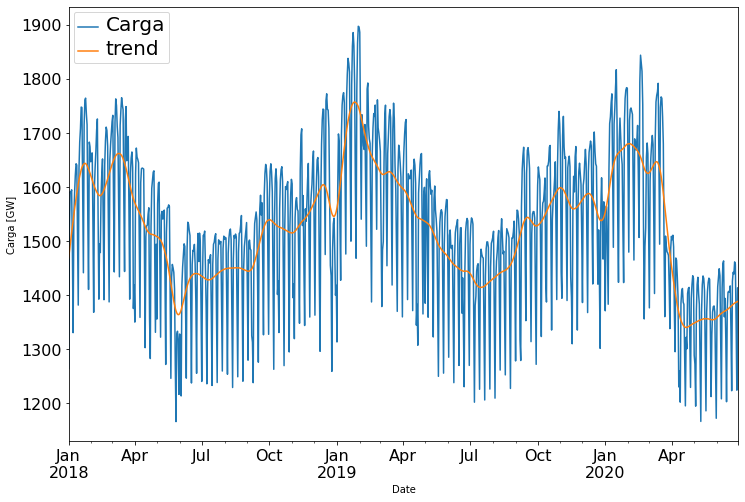

In [29]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
gdp_decomp[["Carga", "trend"]]["2018-01-1":].plot(ax=ax, fontsize=16);
legend = ax.get_legend()
legend.prop.set_size(20);
plt.ylabel('Carga [GW]')

Text(0, 0.5, 'Carga [GW]')

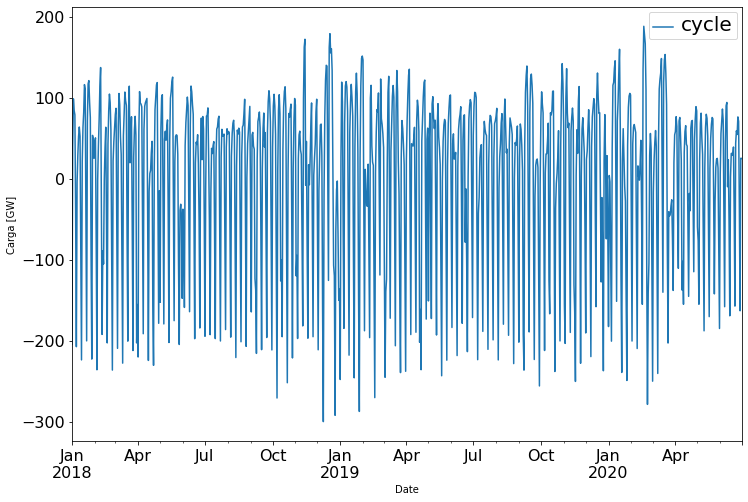

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
gdp_decomp[[ "cycle"]]["2018-01-1":].plot(ax=ax, fontsize=16);
legend = ax.get_legend()
legend.prop.set_size(20);
plt.ylabel('Carga [GW]')

In [31]:
carga.head()

Date
2018-01-01    1264.5
2018-01-02    1519.4
2018-01-03    1591.3
2018-01-04    1588.7
2018-01-05    1594.7
Name: Carga, dtype: float64

# O gráfico a seguir mostra o comportamento da carga no tempo 

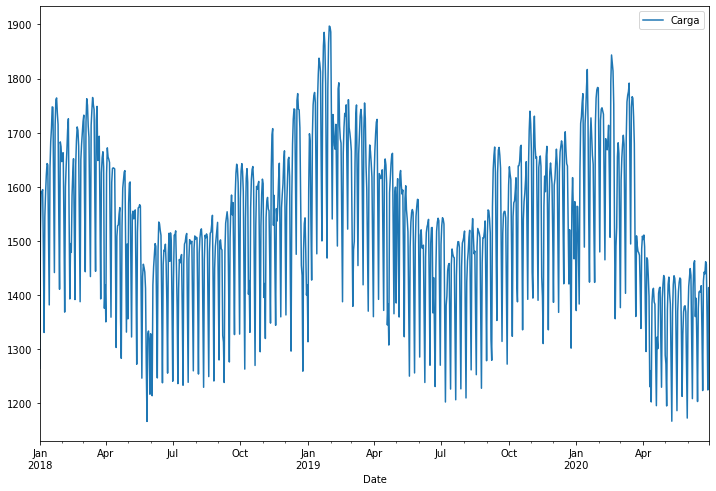

In [32]:
df.plot(figsize=(12,8))